# Regularized regression: US county-level sociodemographic and health resource data (2018-2019)

## 1. Data loading

In [1]:
# Handle imports upfront
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV, Ridge

pd.set_option('display.max_rows', 500)


### 1.1. Load

In [2]:
data_url='https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
data_df=pd.read_csv(data_url, sep=',')

### 1.2. Inspect

In [3]:
data_df.head().transpose()

,0,1,2,3,4
fips,1001,1003,1005,1007,1009
TOT_POP,55601,218022,24881,22400,57840
0-9,6787,24757,2732,2456,7095
0-9 y/o % of total pop,12.206615,11.355276,10.980266,10.964286,12.266598
19-Oct,7637,26913,2960,2596,7570
10-19 y/o % of total pop,13.735364,12.344167,11.896628,11.589286,13.087828
20-29,6878,23579,3268,3029,6742
20-29 y/o % of total pop,12.370281,10.814964,13.13452,13.522321,11.656293
30-39,7089,25213,3201,3113,6884
30-39 y/o % of total pop,12.749771,11.564429,12.865239,13.897321,11.901798


In [4]:
data_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 108 columns):
 #    Column                                                                         Non-Null Count  Dtype  
---   ------                                                                         --------------  -----  
 0    fips                                                                           3140 non-null   int64  
 1    TOT_POP                                                                        3140 non-null   int64  
 2    0-9                                                                            3140 non-null   int64  
 3    0-9 y/o % of total pop                                                         3140 non-null   float64
 4    19-Oct                                                                         3140 non-null   int64  
 5    10-19 y/o % of total pop                                                       3140 non-null   float64
 6    20-29         

### 1.3. Train-test split

In [5]:
# Do the test-train split
training_df, testing_df=train_test_split(
    data_df,
    test_size=0.25,
    random_state=315
)

## 2. EDA

### 2.1. Baseline model performance

In [6]:
anycondition_rates=training_df['anycondition_number']/training_df['TOT_POP']
mean_anycondition_rate=np.mean(anycondition_rates)
print(f'Mean any condition rate: {mean_anycondition_rate:.2f}')

rmse=root_mean_squared_error(anycondition_rates, [mean_anycondition_rate]*len(training_df))
print(f'Mean any condition rate model RMSE: {rmse:.2f}')

Mean any condition rate: 0.36
Mean any condition rate model RMSE: 0.05


### 2.2. Inital feature selection

#### 2.2.1. Drop pathology related features

In [7]:
training_labels=training_df['anycondition_number']/training_df['TOT_POP']
testing_labels=testing_df['anycondition_number']/testing_df['TOT_POP']

path_features=training_df.columns[:83]
training_df=training_df[path_features]
testing_df=testing_df[path_features]

#### 2.2.2. Initial feature selection

In [8]:
string_features=['COUNTY_NAME', 'STATE_NAME']
ordinal_encoder=OrdinalEncoder()
training_df[string_features]=ordinal_encoder.fit_transform(training_df[string_features])

linear_model=LinearRegression()
selector=RFE(linear_model, n_features_to_select=21, step=1)
selector=selector.fit(training_df, training_labels)

training_features=training_df.loc[:, selector.get_support()].copy()
testing_features=testing_df.loc[:, selector.get_support()].copy()

training_features.head().transpose()

,340,1171,2303,967,872
0-9 y/o % of total pop,10.370370,13.701896,10.309383,12.248155,12.748462
10-19 y/o % of total pop,10.901468,12.755894,10.957517,12.068622,13.748225
20-29 y/o % of total pop,16.925227,13.402959,10.324573,10.353082,10.725272
30-39 y/o % of total pop,11.726066,15.506868,10.479012,10.991422,10.571462
40-49 y/o % of total pop,12.096436,11.109850,11.119550,10.572511,10.955987
50-59 y/o % of total pop,13.214535,13.497559,15.448883,13.764213,13.961193
60-69 y/o % of total pop,12.550664,11.174178,15.524837,14.103331,13.541174
70-79 y/o % of total pop,8.266946,5.687365,9.891640,9.136246,7.856129
80+ y/o % of total pop,3.948288,3.163431,5.944605,6.762418,5.892097
% White-alone,62.948987,57.944526,97.713808,95.930580,87.245622


In [9]:
new_columns={
    'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)': 'Primary physicians',
    'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)': 'General surgons'
}

training_features.rename(columns=new_columns, inplace=True)
testing_features.rename(columns=new_columns, inplace=True)

### 2.3. Feature distributions and cleaning

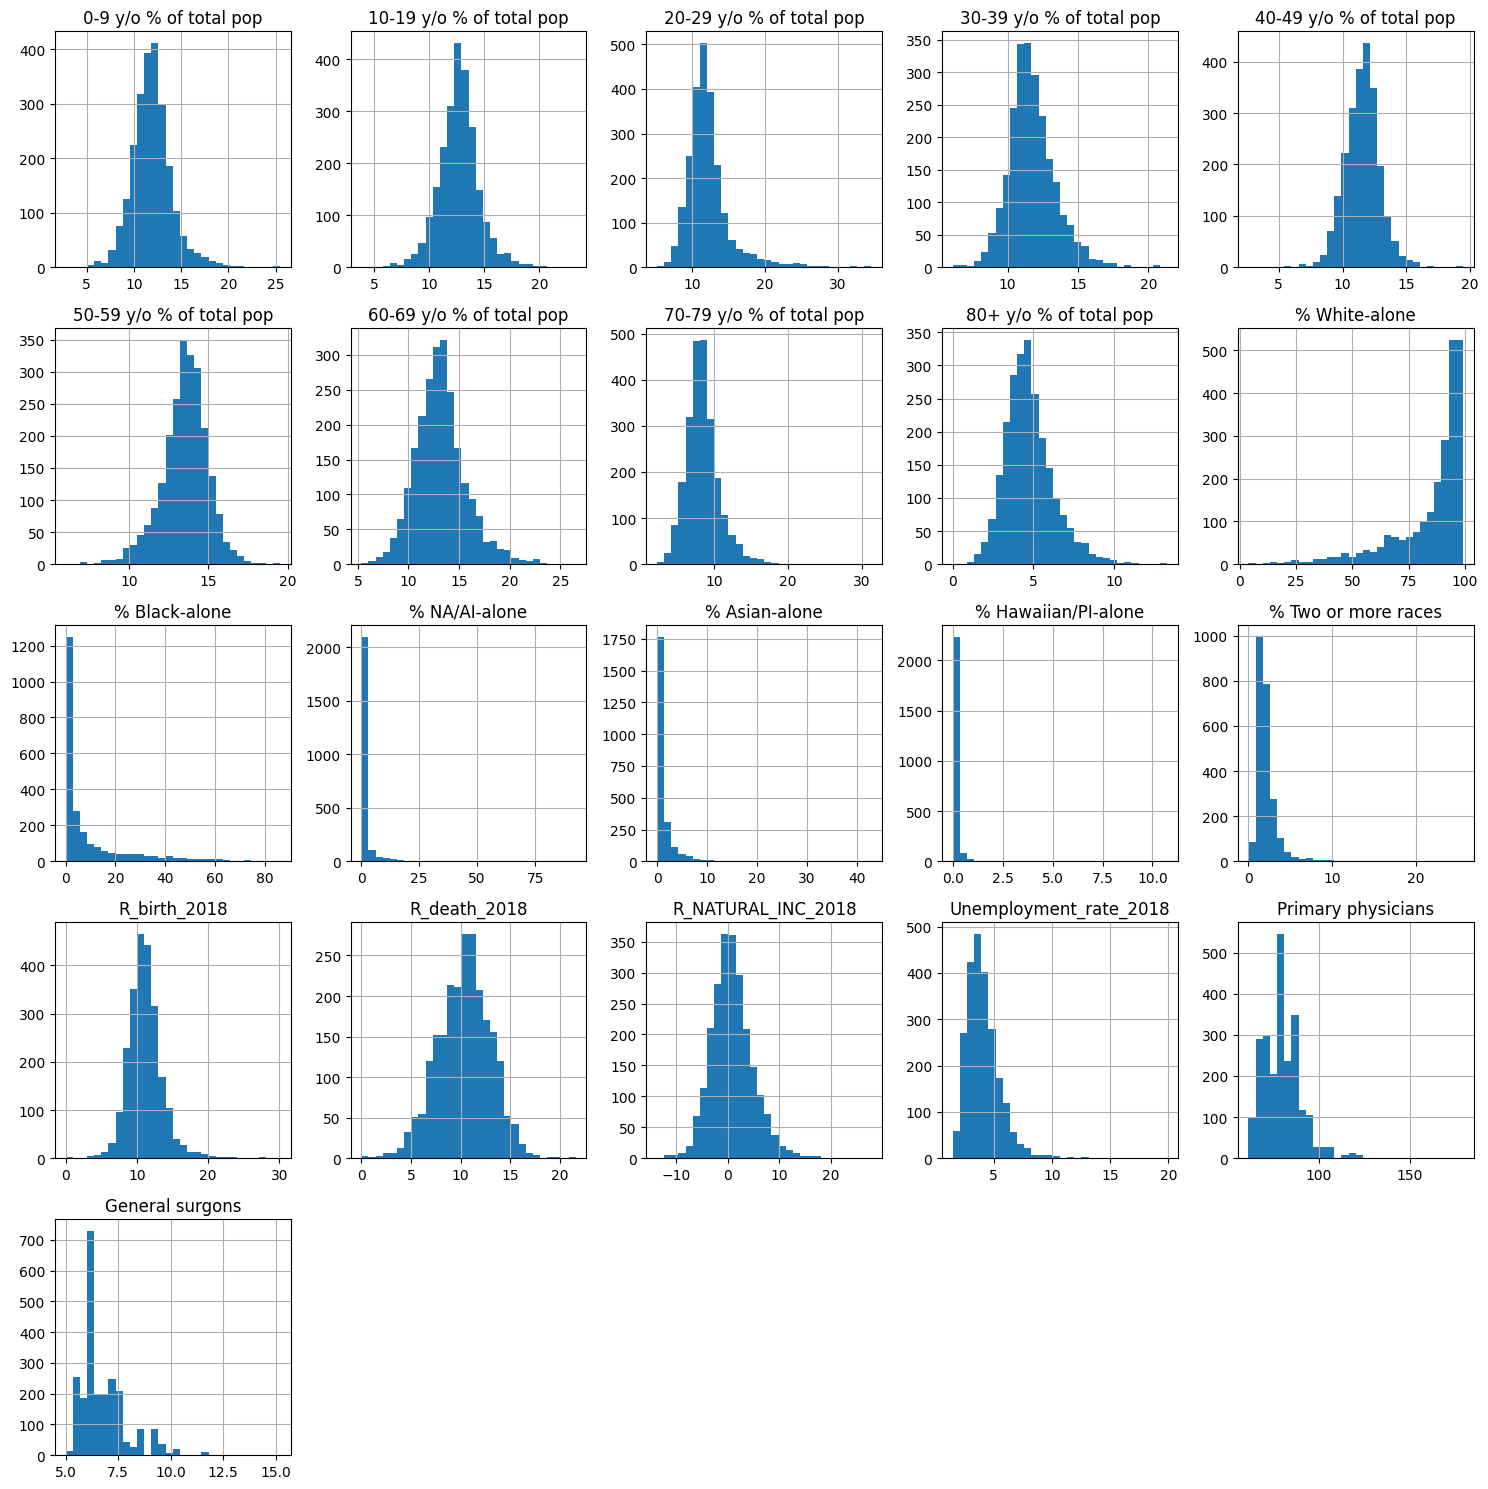

In [10]:
training_features.hist(bins=30, figsize=(15, 15))
plt.tight_layout()
plt.show()

### 2.4. Feature interactions & selection

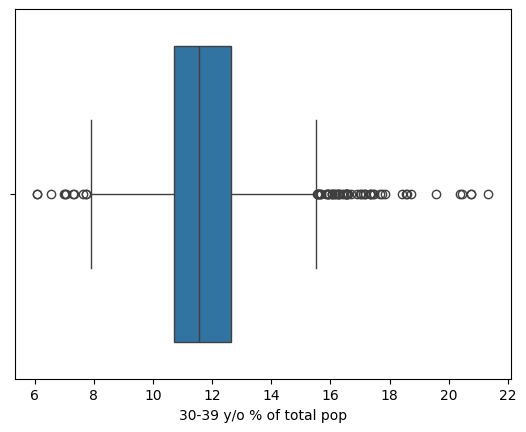

In [11]:
# Your code here...
sns.boxplot(x=training_features['30-39 y/o % of total pop'])
plt.show()

### 2.5. Feature encoding & scaling

In [12]:
# Your code here...
scaler=StandardScaler()
scaler.fit(training_features)
scaled_training_features=scaler.transform(training_features)
scaled_testing_features=scaler.transform(testing_features)

training_features=pd.DataFrame(scaled_training_features, columns=training_features.columns)
testing_features=pd.DataFrame(scaled_testing_features, columns=testing_features.columns)

training_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0-9 y/o % of total pop,2355.0,3.137853e-16,1.000212,-4.295895,-0.613382,-0.035134,0.508631,6.396473
10-19 y/o % of total pop,2355.0,3.168025e-16,1.000212,-4.827438,-0.581758,-0.004905,0.537211,5.772052
20-29 y/o % of total pop,2355.0,-8.749783e-17,1.000212,-2.288984,-0.578351,-0.162421,0.287716,7.301850
30-39 y/o % of total pop,2355.0,-8.825212e-17,1.000212,-3.330568,-0.613984,-0.106590,0.519104,5.650023
40-49 y/o % of total pop,2355.0,1.538755e-16,1.000212,-6.429448,-0.648484,0.038857,0.612433,5.682513
50-59 y/o % of total pop,2355.0,-5.943818e-16,1.000212,-5.118518,-0.538974,0.060673,0.630877,4.080450
60-69 y/o % of total pop,2355.0,3.650772e-16,1.000212,-3.076288,-0.629824,-0.069896,0.510518,5.213889
70-79 y/o % of total pop,2355.0,-4.359806e-16,1.000212,-2.730121,-0.621212,-0.099454,0.471787,10.112260
80+ y/o % of total pop,2355.0,3.168025e-16,1.000212,-3.112725,-0.661244,-0.117121,0.511060,5.612378
% White-alone,2355.0,-4.676608e-17,1.000212,-4.915080,-0.287895,0.423164,0.673967,0.886373


## 3. Linear model training

In [13]:
linear_model=LinearRegression()
result=linear_model.fit(training_features, training_labels)

train_predictions=linear_model.predict(training_features)
train_rmse=root_mean_squared_error(training_labels, train_predictions)

test_predictions=linear_model.predict(testing_features)
test_rmse=root_mean_squared_error(testing_labels, test_predictions)

print(f'Prediction RMSE: training: {train_rmse:.3f}, testing: {test_rmse:.3f}')

Prediction RMSE: training: 0.030, testing: 0.033


## 4. Model regularization

In [14]:
penalties=[0.0001, 0.001, 0.01, 0.1]

for penalty in penalties:
    lasso_model=Lasso(alpha=penalty, max_iter=1000)
    result=lasso_model.fit(training_features, training_labels)

    train_predictions=lasso_model.predict(training_features)
    train_rmse=root_mean_squared_error(training_labels, train_predictions)

    test_predictions=lasso_model.predict(testing_features)
    test_rmse=root_mean_squared_error(testing_labels, test_predictions)

    print(f'Prediction RMSE: training: {train_rmse:.3f}, testing: {test_rmse:.3f}')

Prediction RMSE: training: 0.030, testing: 0.033
Prediction RMSE: training: 0.030, testing: 0.030
Prediction RMSE: training: 0.037, testing: 0.037
Prediction RMSE: training: 0.052, testing: 0.051


In [ ]:
# Perform hyperparameter optimization for Lasso
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(training_features, training_labels)

# Optimal alpha parameter
optimal_alpha_lasso = lasso_cv.alpha_
print(f'Optimal alpha for Lasso: {optimal_alpha_lasso}')


Optimal alpha for Lasso: 0.00015125971077615928


In [21]:
# Train Lasso model with optimal alpha
lasso_model = Lasso(alpha=optimal_alpha_lasso, max_iter=5000)
lasso_model.fit(training_features, training_labels)


Lasso(alpha=np.float64(0.00015125971077615928), max_iter=5000)

## 5. Hyperparameter optimization

In [17]:
# Your code here...

# Perform hyperparameter optimization for Ridge
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(training_features, training_labels)

# Optimal alpha parameter
optimal_alpha_ridge = ridge_cv.alpha_
print(f'Optimal alpha for Ridge: {optimal_alpha_ridge}')


Optimal alpha for Ridge: 10.0


In [24]:
# Train Ridge model with optimal alpha
ridge_model = Ridge(alpha=optimal_alpha_ridge, max_iter=5000)
ridge_model.fit(training_features, training_labels)


Ridge(alpha=np.float64(10.0), max_iter=5000)

## 6. Final model evaluation

In [23]:
# Your code here...
from sklearn.metrics import r2_score

# Evaluate Lasso model
lasso_predictions = lasso_model.predict(testing_features)
lasso_mse = mean_squared_error(testing_labels, lasso_predictions)
lasso_r2 = r2_score(testing_labels, lasso_predictions)
print(f'Lasso Mean Squared Error: {lasso_mse}')
print(f'Lasso R^2 Score: {lasso_r2}')

# Evaluate Ridge model
ridge_predictions = ridge_model.predict(testing_features)
ridge_mse = mean_squared_error(testing_labels, ridge_predictions)
ridge_r2 = r2_score(testing_labels, ridge_predictions)
print(f'Ridge Mean Squared Error: {ridge_mse}')
print(f'Ridge R^2 Score: {ridge_r2}')


Lasso Mean Squared Error: 0.0010401689945884357
Lasso R^2 Score: 0.6021362745783423
Ridge Mean Squared Error: 0.001089814423586535
Ridge R^2 Score: 0.583146941658305
